<a href="https://colab.research.google.com/github/stanfordnmbl/mobilize-tutorials/blob/main/Tutorial_Pose_Estimation_for_Biomechanics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mobilize Center & Restore Center @ Stanford Tutorial
# Pose Estimation for Biomechanics 

Quantitative motion analysis is important for the diagnostics of movement disorders and for research. State-of-the-art measurements involve optical motion capture using reflective markers and expensive cameras to capture trajectories of these markers. Though the technique provides high frequency data for assessment, the cost, skills, and time involved limit wide adoption.

Recent advancements in deep learning allow us to very robustly detect body landmarks (such as toes, hips, shoulders, etc.) in images from commodity cameras, such as found in smartphones. We can apply these techniques to videos to derive trajectories of landmarks in time. Recent studies show that these trajectories can be used for some clinical applications, potentially reducing the cost of movement analyses by orders of magnitude and facilitating more frequent assessments.

##Tutorial Overview
**In this notebook we illustrate how to use one deep learning algorithm to analyze human motion. Specifically, we will extract knee flexion curves and gait cycles from a video of a subject walking.** The notebook is for illustrative purposes only, and multiple improvements should be incorporated to obtain accurate knee flexion angles. However, the notebook does provide a pipeline that you can adapt to get started with video-based pose estimation projects.

The notebook is a part of the [Mobilize Center](https://mobilize.stanford.edu) webinar series, and is jointly offered with the [Restore Center](https://restore.stanford.edu). The Mobilize Center is an NIH-funded Biomedical Technology Resource Center which provides tools and training to help researchers produce insights from wearables, video, medical images, and other data sources. The Restore Center is an NIH Medical Rehabilitation Research Resource Network Center which is creating a worldwide collaboration to advance the use of real-world data in rehabilitation outcomes for those with movement impairments.

##Background and Citation
Most of the [code](https://github.com/stanfordnmbl/mobile-gaitlab) in this notebook comes from our study on gait analysis in the cerebral palsy population. To cite our work, please use:

*Łukasz Kidziński, Bryan Yang, Jennifer L. Hicks, Apoorva Rajagopal, Scott L. Delp, and Michael H. Schwartz. "Deep neural networks enable quantitative movement analysis using single-camera videos." Nature communications 11, no. 1 (2020): 1-10.*

Learn more about this work:
* [Read our publication](https://www.nature.com/articles/s41467-020-17807-z)
* Watch the video abstract of this study below

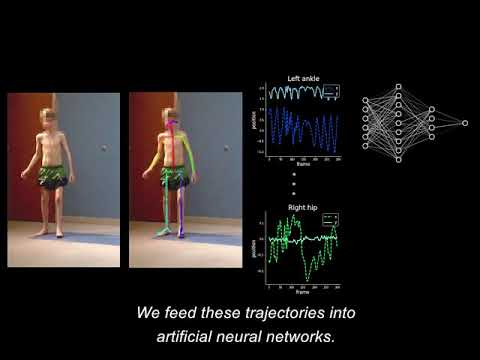

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('pb4WvAhsRe4')

## Learning Goals

In this tutorial notebook, you will learn how to:

* Set up a Google Colab notebook to run OpenPose
  - Download OpenPose
  - Download a sample video
* Run OpenPose on a sample video and work with its output
  - Interpret output JSON files
  - Convert files to a numpy time series
* Preprocess data
  - Fix missing data with interpolation
  - Fix noise with a Gaussian filter
  - Fix bias with normalization
* Perform the analysis
  - Derive joint angles
  - Find gait cycles
  - Report results



**Prefer to follow along via video?** [Access a recording](https://www.youtube.com/watch?v=Js0uRTLfm6s&t=4s) of Łukasz Kidziński guiding users through this tutorial

# Setup




## Introduction to Google Colab

Google Colab is a cloud-based environment for running Python code interactively (via Jupyter notebooks, for those who are familiar with those). If you are new to Colab, you can learn about the key features in [this tutorial](https://colab.research.google.com/notebooks/basic_features_overview.ipynb). For the purposes of our tutorial, you only need to understand how to interact with the "code cells." In the [webinar recording](https://www.youtube.com/watch?v=Js0uRTLfm6s&t=4s), we also provide a quick overview of how to work with this Colab notebook.


## Installation

Run the code below to download and compile OpenPose within your Google Colab environment (based on [tugstugi/dl-colab-notebooks](https://github.com/tugstugi/dl-colab-notebooks)). **This takes around 1 minute.** It is done when you see `[100%] Built target openpose_net`.

In [ ]:
import os
if not os.path.exists("openpose"):
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  !pip install -q youtube-dl
  !wget https://mc-motionlab-storage.s3-us-west-2.amazonaws.com/openpose.tar.gz
  !tar -zxvf openpose.tar.gz
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  !cd openpose/build && cmake .. && make -j`nproc`

## Detect poses in a test video

We are going to detect poses on a sample video from a clinic. In this case, the video is stored at https://github.com/stanfordnmbl/mobile-gaitlab/raw/master/demo/in/input.mp4.

Click the Files folder icon fileFolderIcon.jpg in the left-hand column to see the current files in your virtual Colab environment. After you run the code below, refresh the folder by clicking on the folder icon with the circular arrow refreshFolderIcon.jpg. You should see a new file called "input.mp4" in your list of files.

In [ ]:
# Download the video
!wget https://github.com/stanfordnmbl/mobile-gaitlab/raw/master/demo/in/input.mp4

Let's view the video to see what we will be analyzing.

In [ ]:
# Define function to display the video
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

# Display the video
show_local_mp4_video('input.mp4', width=960, height=720)

We will now run OpenPose, specifying our input video file (`input.mp4`) and asking it to output the following:

* The body keypoints in a JSON format in the directory `openpose/output` and 
* A video of the keypoints (`openpose.avi`)

Several other input, output, and run options are available and are described in the [OpenPose documentation](https://cmu-perceptual-computing-lab.github.io/openpose/web/html/doc/).

In the code below, we also convert the output video into an MP4 video (`output.mp4`) for viewing.

NOTE: For these examples, the openpose command must be run from the openpose folder, so that it can locate the supporting files. 

In [ ]:
# delete files from previous runs of this script
!rm openpose.avi

# detect poses in these video frames using OpenPose
!cd openpose && ./build/examples/openpose/openpose.bin --video ../input.mp4 --write_json ./output/ --display 0  --write_video ../openpose.avi

# convert the video output result into MP4 so we can visualize it using the 'show_local_mp4_video' function we defined above
!ffmpeg -y -loglevel info -i openpose.avi output.mp4

TROUBLESHOOTING: If you get an error message about `Cuda check failed`, this is likely because Google Colab cannot allocate a GPU for you to run OpenPose. Make sure you have set the notebook to use the GPU: 


1.   Select Runtime->Change runtime type 
2.   Choose `GPU` from the pull-down
1.   Click `SAVE`

If the setting is correct, try running the notebook at another time.


Finally, we can visualize the results: 

In [ ]:
show_local_mp4_video('output.mp4', width=960, height=720)

## View and interpret OpenPose JSON output

The output of OpenPose for each frame is saved in a JSON file. 

You can view the list of output files by clicking on the Files folder openpose -> output. There you will see a list of files named using the format `input_###_keypoints.json` where ### is a number.  

Let's print out one of these files to see its structure.

In [ ]:
# Load JSON file
import json

with open('openpose/output/input_000000000100_keypoints.json') as json_file:
    data = json.load(json_file)

print(json.dumps(data, indent=4))

The information in the JSON file is stored in an array named `data`. For each frame, OpenPose tries to detect all the people in it. The coordinates of each person are stored in the `data["people"]` list. You access the keypoints in this way: `data["people"][i]["pose_keypoints_2d"]`, where `i` is the index of the person (with the first person having an index of 0). Each person is encoded as a 75-dimensional vector, 3 values for each of 25 different keypoints. Columns with indexes `3*k, 3*k+1` and `3*k+2` correspond to `X, Y` and `confidence` of the given keypoint, where `k` is the index of the keypoint (where the first keypoint has an index of 0). Please refer to the figure below for interpretation of the index `k`.

Example: To access the `X` value of the second keypoint (k=1), you would use the following: `data["people"][0]["pose_keypoints_2d"][3]` 

![picture](https://user-images.githubusercontent.com/29478970/76984773-94e34580-693f-11ea-9bcd-7af6fbb1d521.png)

For clarity, we name all indices using short keywords, for example, an index of 2 refers to the right shoulder (RSHO):

In [ ]:
NOSE = 0
NECK = 1
RSHO = 2
RELB = 3
RWRI = 4
LSHO = 5
LELB = 6
LWRI = 7
MHIP = 8
RHIP = 9
RKNE = 10
RANK = 11
LHIP = 12
LKNE = 13
LANK = 14
REYE = 15
LEYE = 16
REAR = 17
LEAR = 18
LBTO = 19
LSTO = 20
LHEL = 21
RBTO = 22
RSTO = 23
RHEL = 24

print("DONE: Short keywords assigned")

## Convert JSON files to a time series of keypoints

To run our analysis, we want to load data from all the JSON files into memory. In this case, we name that data array `res`. We will loop through all the files and use the functions from the numpy (np) package to store the subject's data as an array with 344 rows (one for each file/frame) and 75 columns. In our script, we determine the number of frames by counting the number of files in the directory.

NOTE: We are using our knowledge/assumption that there is only one person visible in each frame.

In [ ]:
import numpy as np
import pandas as pd

def convert_json2csv(json_directory):
    # determine the number of frames
    nframes = len(os.listdir(json_directory))
  
    # initialize res to be array of NaN
    res = np.zeros((nframes,75))
    res[:] = np.nan
    
    # read in JSON files
    for frame in range(0,nframes):
        test_image_json = '%sinput_%s_keypoints.json' %            (json_directory, str(frame).zfill(12))

        if not os.path.isfile(test_image_json):
            break
        with open(test_image_json) as data_file:  
            data = json.load(data_file)

        for person in data['people']:
            keypoints = person['pose_keypoints_2d']
            xcoords = [keypoints[i] for i in range(len(keypoints)) if i % 3 == 0]
            counter = 0
            res[frame,:] = keypoints
            break

    return res

res = convert_json2csv("openpose/output/")
pd.DataFrame(res) # only for clean display

# Preprocessing



## Diagnostic plots

Now we plot some of the trajectories to see whether we need to clean them up using signal processing techniques.

In [ ]:
import matplotlib.pyplot as plt

plt.plot(res[:,(NOSE*3)])
plt.plot(res[:,(NOSE*3+1)])
plt.xlabel("video frame")
plt.ylabel("nose position")
plt.legend(('x','y'))

Above we plotted the trajectory of the NOSE keypoint (index = 0). We see that around frame 150, there is some discontinuity. Also, some high frequency noise is present in the signals. Let's check if the same problems show up in curves that we are interested in for computing knee flexion, i.e., trajectories of the right ankle, knee, and hip.

In [ ]:
# Features to plot for diagnostics
PLOT_COLS = {
    "Right ankle": RANK,
    "Right knee": RKNE,
    "Right hip": RHIP,
}

# The show_plots function displays a set of curves for each keypoint.
# We will use the show_plots again with different data arrays, 
# so we include the cols_per_point argument to provide flexibility 
# in specifying how many columns of the array are associated with a 
# given keypoint.
def show_plots(keypoint_array, cols_per_point=3):
    for name, col in PLOT_COLS.items():
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.title(name,fontsize=24)
        plt.xlabel("video frame",fontsize=17)
        plt.ylabel("position",fontsize=17)

        plt.plot(keypoint_array[:,[col*cols_per_point,]], linestyle="-", linewidth=2.5)
        plt.plot(keypoint_array[:,[col*cols_per_point+1,]], linestyle="-", linewidth=2.5)
        plt.legend(['x', 'y'],loc=1)

show_plots(res)

We also see discontinuity and some high frequency noise in these signals, so we will clean them up using signal processing techniques.

## Clean up signals

**Discontinuities and Missing Data:** We will treat the discontinuities like missing data and use linear interpolation to fill in the missing data. There are several other ways to deal with missing data, and we encourage you to explore these for your research projects. You can find many resources online on this topic (search for "missing data in time series"), so we will not go over this here. We use linear interpolation because it is straightforward. 

For the interpolation process, we first want to simplify the data we use. We will copy the JSON output data into the `res_processed` variable, drop the confidence column which we don't need for interpolation, and replace values for undetected keypoints with NaN.

In [ ]:
# The 3rd column associated with each keypoint in the OpenPose output 
# is the confidence score. We won't be using it in this notebook so 
# we can drop it

def drop_confidence_cols(keypoint_array):
    num_parts = keypoint_array.shape[1]/3 # should give 25 (# of OpenPose keypoints)
    processed_cols = [True,True,False] * int(num_parts) 
    return keypoint_array[:,processed_cols]

res_processed = res.copy()
res_processed = drop_confidence_cols(res_processed)

# if keypoint is not detected, OpenPose returns 0. For undetected keypoints,
# we change their values to NaN. Wo do it for all dimensions of all keypoints
# in all frames at once
res_processed[res_processed < 0.0001] = np.NaN 

# Note that we use res_processed < 0.0001 instead of res_processed == 0.0.
# While in the case of this video it makes no difference, it is usually
# a good practice in computer science to account for the fact that 
# 0.0 might be actually actually represented as a number slightly greater than
# 0. See more on this topic here
# https://randomascii.wordpress.com/2012/02/25/comparing-floating-point-numbers-2012-edition/

pd.DataFrame(res_processed)

You will see that this new data array only has 50 columns, compared with the original 75, reflecting the deletion of the columns with the confidence values. Also, notice that the first time point for keypoint 17 (columns 34 and 35 in row 0) now have NaN, replacing the zeros that were originally in columns 51 and 52 of that row.

Next, we replace NaNs with linearly interpolated values and we plot the results to see that the discontinuities are no longer present.

For those interested in understanding the details of the code, the key functions here are:

* `interpolate.interp1d`, which performs the 1D interpolation and is provided through SciPy. The 
full documentation for this function is located [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html).
*  `np.nanmean`, which computes the mean for an array (ignoring NaN) and is provided through the NumPy package for scientific computing. The full documentation for this function is located [here](https://numpy.org/doc/stable/reference/generated/numpy.nanmean.html?highlight=nanmean#numpy.nanmean).

In [ ]:
from scipy import interpolate

# interpolate to fill nan values
def fill_nan(A):
    inds = np.arange(A.shape[0]) 
    good = np.where(np.isfinite(A))
    if(len(good[0]) <= 1):
        return A
   
    # linearly interpolate and then fill the extremes with the mean (relatively similar to)
    # what kalman does 
    f = interpolate.interp1d(inds[good], A[good],kind="linear",bounds_error=False)
    B = np.where(np.isfinite(A),A,f(inds))
    B = np.where(np.isfinite(B),B,np.nanmean(B))
    return B
    
def impute_frames(frames):
    return np.apply_along_axis(fill_nan,arr=frames,axis=0)

res_processed = impute_frames(res_processed)
show_plots(res_processed, 2)

**Noisy Data:** We remove high frequency noise by smoothing the data with a Gaussian filter. Since the observed noise is of low magnitude and high frequency, it is relatively easy to filter out this noise with many popular methods. We chose the Gaussian filter in this tutorial for its simplicity of use.

There are a number of other approaches for removing high frequency noise in a signal. Which is appropriate depends on the nature of your data. These [course notes](https://ggbaker.ca/data-science/content/filtering.html) from Greg Baker at Simon Fraser University provide a useful explanation of some of these other options. 

In this example, we use a Gaussian kernel with a standard deviation of 1. The documentation for the `gaussian_filter1d` function we use is [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter1d.html). 


In [ ]:
from scipy.ndimage.filters import gaussian_filter1d

# Remove high frequency noise
def filter_frames(frames, sd=1):
    return np.apply_along_axis(lambda x: gaussian_filter1d(x,sd),
                               arr = frames,
                               axis = 0)

res_processed = filter_frames(res_processed, 1)
show_plots(res_processed, 2)

If you compare these curves with the ones produced in the previous cell, you will notice that these curves are much smoother.

**Bias:** Bias refers to a systemic error. In our case, the manner in which the video was recorded resulted in subjects systemically appearing smaller, then larger, and then smaller again due to the changing camera angle and distance from the subject. This resulted in varying lengths for the body parts that did not accurately reflect reality.

To compensate for this bias, we therefore normalize each frame by (approximately) the length of the subject's femur. The premise is to choose a segment of a fixed length and divide all dimensions by this length. As a result, each pose has exactly the same normalized femur length, and the other segments have a length defined relative to the femur length. The length for each segment should be fairly constant from frame to frame, since they have a relatively fixed proportion to the femur in each frame. We chose the femur as it's relatively long, and therefore its measurement is more robust to noise.

In [ ]:
# Find mean and standard deviation for debiasing
def find_mid_sd(signal_array):
    num_parts = signal_array.shape[1]/2 

    # Derive mid hip position
    mhip_x = ((signal_array[:,2*RHIP] + signal_array[:,2*LHIP])/2).reshape(-1,1)
    mhip_y = ((signal_array[:,2*RHIP+1] + signal_array[:,2*LHIP+1])/2).reshape(-1,1)
    mhip_coords = np.hstack([mhip_x,mhip_y]*int(num_parts))

    # Normalize to hip-knee distance
    topoint = lambda x: range(2*x,2*x+2)
    scale_vector_R = np.apply_along_axis(lambda x: np.linalg.norm(x[topoint(RHIP)] -
                                                                  x[topoint(RKNE)]),1,signal_array)
    scale_vector_L = np.apply_along_axis(lambda x: np.linalg.norm(x[topoint(LHIP)] -
                                                                  x[topoint(LKNE)]),1,signal_array)
    scale_vector = ((scale_vector_R + scale_vector_L)/2.0).reshape(-1,1)
    return mhip_coords, scale_vector

res_mhip_coords, res_scale_vector = find_mid_sd(res_processed)
res_processed = (res_processed-res_mhip_coords)/res_scale_vector
show_plots(res_processed, 2)

Note how the y coordinate (orange) in the normalized curve varies around a fairly constant position, compared to the plots in the previous cell without normalization! In the previous cell, the y position (orange) displayed an underlying "u" shape.

# Analysis



## Derive joint angles

As we are interested in the knee flexion angle, we will look at the angle formed by the keypoints at the ankle, knee, and hip. We do this by taking the arccosine of the normalized dot product between the ankle-knee vector and the knee-hip vector.

In [ ]:
def get_angle(A,B,C,centered_filtered):
   
    # finds the angle ABC, assumes that confidence columns have been removed
    # A,B and C are integers corresponding to different keypoints
    
    p_A = np.array([centered_filtered[:,2*A],centered_filtered[:,2*A+1]]).T
    p_B = np.array([centered_filtered[:,2*B],centered_filtered[:,2*B+1]]).T
    p_C = np.array([centered_filtered[:,2*C],centered_filtered[:,2*C+1]]).T
    p_BA = p_A - p_B
    p_BC = p_C - p_B
    dot_products = np.sum(p_BA*p_BC,axis=1)
    norm_products = np.linalg.norm(p_BA,axis=1)*np.linalg.norm(p_BC,axis=1)
    return np.arccos(dot_products/norm_products)

# get the knee angle and convert from radians to degrees
knee_angle = (np.pi - get_angle(RANK, RKNE, RHIP, res_processed))*180/np.pi

# plot the knee angle
plt.plot(knee_angle)
plt.xlabel("video frame")
plt.ylabel("knee angle (degrees)")

## Divide time series into gait cycles

As we are interested in the knee flexion over a gait cycle, we will divide the time series into segments. For simplicity, we will define a gait cycle as a *segment between timepoints when a) the distance between the toes on the right and left legs are at a maximum **and** b) the right toes are on the right and the left toes are on the left in the sagittal plane view*.

First, we will compute the distance between the toes on the right and left legs and store that in the variable `dst_org`. We then plot that distance.

In [ ]:
def get_distance(A,B,centered_filtered):
    p_A = np.array([centered_filtered[:,2*A],centered_filtered[:,2*A+1]]).T
    p_B = np.array([centered_filtered[:,2*B],centered_filtered[:,2*B+1]]).T    
    p_BA = p_A - p_B
    return np.linalg.norm(p_BA,axis=1)

dst_org = get_distance(RBTO, LBTO, res_processed) * np.sign(res_processed[:,LBTO*2] - res_processed[:,RBTO*2])
plt.plot(dst_org)
plt.xlabel("video frame")
plt.ylabel("distance between right and left toes")

In the plot above, there is some noise around on either side of frame 100, so we'll smooth the signal using a Gaussian filter as we did previously. The smoothed distance data is stored in the variable `dst`.

In [ ]:
dst = gaussian_filter1d(dst_org.copy(),5)
plt.plot(dst)
plt.xlabel("video frame")
plt.ylabel("distance between right and left toes, smoothed")

Now we need to detect the maximum distance between the toes. We will do that by finding the peaks, which are clearly visible. We will use a simple algorithm for peak detection and store the indices for the peaks, along with the peak values, in a two-column variable called `maxs`.

In [ ]:
# Peak detection script converted from MATLAB script
# at http://billauer.co.il/peakdet.html
#    
# Returns two arrays
#    
# function [maxtab, mintab]=peakdet(v, delta, x)
# PEAKDET Detect peaks in a vector
# [MAXTAB, MINTAB] = PEAKDET(V, DELTA) finds the local
# maxima and minima ("peaks") in the vector V.
# MAXTAB and MINTAB consists of two columns. Column 1
# contains indices in V, and column 2 the found values.
#     
# With [MAXTAB, MINTAB] = PEAKDET(V, DELTA, X) the indices
# in MAXTAB and MINTAB are replaced with the corresponding
# X-values.
#
# A point is considered a maximum peak if it has the maximal
# value, and was preceded (to the left) by a value lower by
# DELTA.
#
# Eli Billauer, 3.4.05 (Explicitly not copyrighted).
# This function is released to the public domain; Any use is allowed.
def peakdet(v, delta, x = None):
    maxtab = []
    mintab = []
       
    if x is None:
        x = np.arange(len(v))
    
    v = np.asarray(v)
    
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    
    if not np.isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    
    mn, mx = np.Inf, -np.Inf
    mnpos, mxpos = np.NaN, np.NaN
    
    lookformax = True
    
    for i in np.arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return np.array(maxtab), np.array(mintab)

maxs, mins = peakdet(dst, 0.5)

print("DONE: maximums and minimums identified")

We now add vertical lines to the identified peak locations in the plot below. This will allow us to do a visual check to see if the peaks are identified correctly. 

In [ ]:
# plot the smoothed distance curve
plt.plot(dst)
plt.xlabel("video frame")
plt.ylabel("distance between right and left toes, smoothed")

# plot a vertical line at each point identified to have a maximum
for mm in maxs.tolist():
     plt.axvline(x=mm[0], color="orange")

The peaks appear to be identified correctly, so we will use 
these video frames to similarly mark the split between gait cycles on the knee angle time series.

In [ ]:
# plot the knee angle curve
plt.plot(knee_angle)
plt.xlabel("video frame")
plt.ylabel("knee angle (degrees)")

# plot a vertical line at each split between gait cycles
for mm in maxs.tolist():
     plt.axvline(x=mm[0], color="orange")

We will extract the knee angles for the first 4 full segments, or gait cycles in this case, and store them in the variable `segments` to be used for further analysis and visualization.

In [ ]:
segments = []
sstart = int(maxs[0][0])
for i in range(1,5):
    end = int(maxs[i][0])
    segments.append(knee_angle[sstart:end])
    print("Segment from {} to {}".format(sstart,end))
    sstart = end

# Report results



## Plot knee angle for four gait cycles and export the plot

We can now visually compare the knee angle over the first four gait cycles. After you run the cell below, you should see a plot with four curves, one for each gait cycle. Using the `plt.savefig` command, we also exported this plot to a file called "curves.png" that should appear in your Files folder to the left.

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title("Approx. planar knee angle",fontsize=24)
plt.xlabel("gait cycle (in %)",fontsize=17)
plt.ylabel("angle (in degrees)",fontsize=17)

# Because each gait cycle has a slightly different number of points, 
# we must interpolate the data for each gait cycle so that
# each gait cycle has the same number of points in order to plot
# them together. Here we choose 100 points.
grid = np.linspace(0.0, 1.0, num=100)
curves = np.zeros([4,100])

for i in range(4):
    org_space = np.linspace(0.0, 1.0, num=int(segments[i].shape[0]))
    f = interpolate.interp1d(org_space, segments[i], kind="linear")
    plt.plot(grid*100, f(grid), linestyle="-", linewidth=2.5)
    plt.legend(["Cycle {}".format(k) for k in range(1,5)],loc=1)
    curves[i,:] = f(grid)

plt.savefig("curves.png")

## Export cleaned up trajectories

We can also save any of our data to a text file. Below we save the trajectories from the first four gait cycles to a file called "trajectories.csv." After running the cell below, you should see that file in your Files folder to the left.

In [ ]:
np.savetxt("trajectories.csv", curves, delimiter=",")

# Experiment with the Code

Congratulations! You've completed your first video analysis with OpenPose. Here are a few activities you can try to increase your familiarity with the code. They are ordered from simplest to most complex.

* Change the variance of the Gaussian smoothing filter to 5. How does this change the calculated joint angles?
* Plot 4 gait cycles of the ankle flexion angle
* Compute the mean and variance of peak knee flexion across 4 gait cycles
* Run the scripts on another video https://github.com/stanfordnmbl/mobile-gaitlab/blob/master/demo/in/input1.mp4?raw=true. Note that because of people in the background, this video needs more preprocessing. Some of the assumptions we made in the code above will no longer be true.
* Install keras and run neural networks from our study (https://github.com/stanfordnmbl/mobile-gaitlab/) to get better predictors of gait parameters from videos. 

# Other resources

* Our publication on our study on gait analysis in Cerebral Palsy population: https://www.nature.com/articles/s41467-020-17807-z
* Code from our study and demo of neural networks: https://github.com/stanfordnmbl/mobile-gaitlab
* OpenPose repository: https://github.com/CMU-Perceptual-Computing-Lab/openpose
* Facebook's software for estimating 3d poses in videos: https://github.com/facebookresearch/VideoPose3D
* DeepLabCut, software for creating virtual markers for different body parts in different species (not just humans) from videos: http://www.mousemotorlab.org/deeplabcut


#Feedback

This notebook is a work-in-progress and we welcome your feedback on how to increase its usefulness. Email comments to us at [mobilize-center@stanford.edu](mailto:mobilize-center@stanford.edu) or submit an issue on GitHub.



---



Version 1.04

Creator: Lukasz Kidzinski | Contributors: Lukasz Kidzinski, Joy Ku  
Last Updated on Mar. 10, 2021

This notebook is made available under the [Apache 2.0 license](https://www.apache.org/licenses/LICENSE-2.0).

Note that software used within the notebook might have different licenses. Please refer to the documentation for individual software and packages. In particular, OpenPose is free only for non-commercial use (see its [license](https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/LICENSE) for details). For an open-source alternative , see [Detectron2](https://github.com/facebookresearch/detectron2) for a keypoint detection algorithm under Apache 2.0 license.